# Prévision des ventes d'un restaurant

Ce notebook présente un exemple de prévision des ventes d'un restaurant à partir de données historiques.

__Date__ : 05/06/2023

__Auteur__ : Ilyas Baktache, Carl-André Gassette


In [1]:
# On importe notre librairie de pré-traitement
import os
import sys
sys.path.append(os.path.dirname( os.path.dirname( os.path.abspath('dionysos') ) ) )

# Pre-processing library
from prevision.data.pre_process import *

# model library
from prevision.model_class import ModeleXG,GeneralModel,modele_rnn

# Data manipulation library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data

Le choix des données est très important pour la qualité de notre modèle. Nous avons choisi d'utiliser les données suivantes:

* Les données du nombre de spectateurs attendus pour les événements autour de la cage aux sports. Ces données peuvent fournir des informations sur l'affluence et l'intérêt des gens pour les événements, ce qui peut avoir un impact sur les ventes. Les types d'évenements comportent:
    * Les évenements sportifs
    * Les conférences
    * Les expositions
    * Les concerts
    * Les festivals
    * Les performances artistiques
    * Les reunions communautaires 


* Les données de la météo, telles que la température, la précipitation et la neige. La météo peut jouer un rôle important dans les comportements d'achat des consommateurs. Par exemple, les jours de pluie ou de neige peuvent influencer les décisions des gens de se rendre aux événements ou de consommer des produits spécifiques.
* Le jour de la semaine : Nous pouvons ajouter une variable binaire ou utiliser l'encodage one-hot pour représenter le jour de la semaine (par exemple, lundi, mardi, etc.). Cela peut permettre de capturer les variations saisonnières ou les tendances hebdomadaires dans nos données. Par exemple, les ventes peuvent être plus élevées le week-end par rapport aux jours de semaine.
* La saison ou le mois : L'inclusion de cette variable peut aider le modèle à capturer les tendances saisonnières et les variations de comportement des ventes. Par exemple, les ventes peuvent augmenter pendant les mois d'été en raison des vacances et des activités estivales.
* Les vacances scolaires et les jours fériés : Nous ajoutons une variable binaire pour indiquer si le jour correspond à une période de vacances ou non. Les comportements d'achat peuvent varier pendant ces périodes, et il est important de les prendre en compte pour obtenir des prédictions précises.

En incluant ces différentes variables, nous espérons capturer les facteurs clés qui influencent les ventes et améliorer la précision de notre modèle. Cependant, il est important de noter que l'inclusion de trop de variables peut également entraîner un surajustement (overfitting) du modèle, il est donc nécessaire de trouver un équilibre et d'évaluer l'impact de chaque variable sur les performances du modèle.

On crée ensuite un dictionnaire. On note alors:

* X les variables d'entrée de notre modèle
* y la variable de sortie de notre modèle


In [2]:
# Date de début et de fin de la saison
start_date = "2023-03-08"
end_date = "2023-06-05"

chemin_fichier_csv = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('dionysos'))),'prevision', 'data')
X,y = pre_process.get_data(start_date,end_date,big_chemin = chemin_fichier_csv + '/')

# on affiche les 5 premières lignes de notre dataset
print("On récupere les features et la target avec respectivement des dimensions {} et {}\n".format(X.shape,y.shape))
print(X.head())
print("\n")
# on affiche les 5 premières lignes de notre target
print(y.head())

On récupere les features et la target avec respectivement des dimensions (77, 20) et (77,)

   spec_sports  spec_conferences  spec_expos  spec_concerts  spec_festivals  \
0          0.0               0.0         0.0            0.0         18692.0   
1      21105.0               0.0         0.0         3007.0         18692.0   
2          0.0               0.0         0.0        10770.0         18692.0   
3      21105.0               0.0     30435.0         3638.0         18692.0   
4        300.0               0.0     36522.0         8335.0         23364.0   

   spec_performing_arts  spec_community  prevision  mean_temp  rain  snow  \
0                   0.0             0.0     9000.0       -7.5   0.0  0.00   
1                 772.0             0.0    14000.0      -10.0   0.1  1.47   
2                   0.0             0.0    16000.0       -7.5   0.0  0.00   
3                 773.0             0.0    22000.0       -5.9   0.0  0.00   
4                 773.0           100.0    20000

/Users/mac2021/Documents/Projet/Projet Dionysos/dionysos/prevision/data/pre_process.py:283: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if debut_vacances <= date <= fin_vacances:


On remarque que les prévisions sont dans les valeurs X mais elle ne seront pas prise en compte par la suite dans notre modèle. On split ensuite nos données en données d'entrainement et de test en récuperant les previsions de la cage actuelle qui seront utilisées pour tester notre modèle.

In [3]:
X_train, X_test, y_train, y_test, prevision_cage = pre_process.split(X, y,random_state = 42)

# Modèle

## Modèle Xg Boost 

On utilise un modèle xg Boost pour prédire les ventes de la cage aux sports. On utilise une cross validation (Random search) pour trouver les meilleurs hyper-paramètres du modèle. On utilise ensuite ces hyper-paramètres pour entrainer notre modèle sur les données d'entrainement. On affiche ensuite les résultats de notre modèle sur les données de test.

### Hyper-paramètres




[07/06/2023 04:56:04] Recherche des meilleurs hyperparamètres
Fitting 5 folds for each of 20 candidates, totalling 100 fits


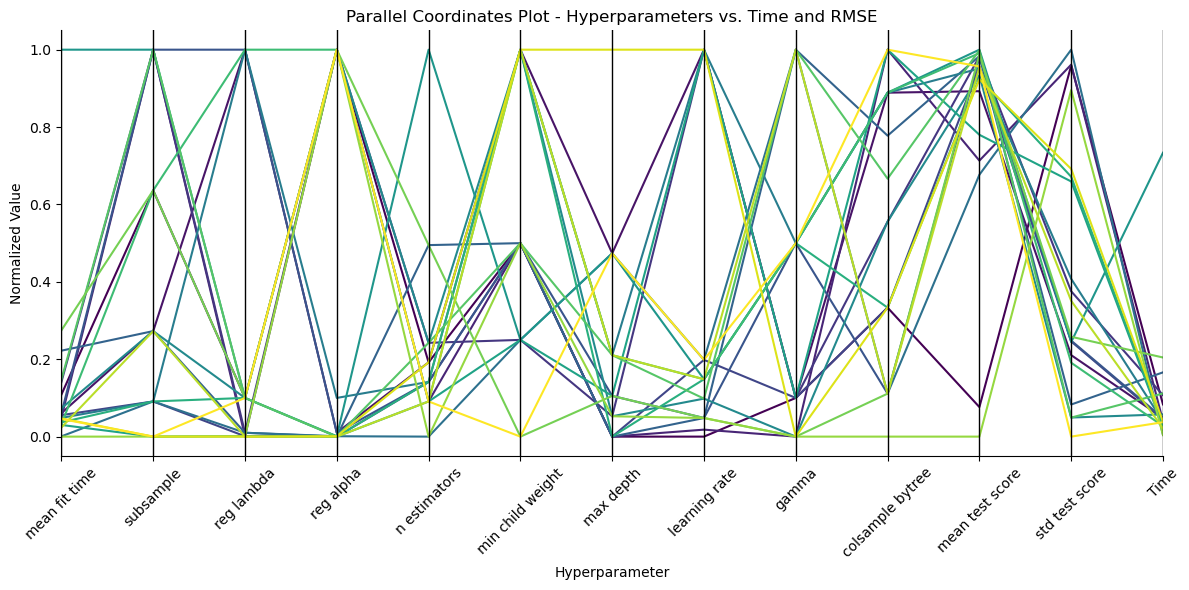

Meilleurs hyperparamètres : {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 50, 'learning_rate': 0.075, 'gamma': 0.5, 'colsample_bytree': 0.9}
MSE : 3468.016849965432
MAE : 2921.350461425781


In [4]:
print("[" + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + "] Recherche des meilleurs hyperparamètres")
best_params, best_model = ModeleXG.hyperparametres_random(X_train, y_train, X_test, y_test,plot = True,param = 'MAE')

### Impacte des features

On affiche l'impacte des features sur les prédictions de notre modèle.

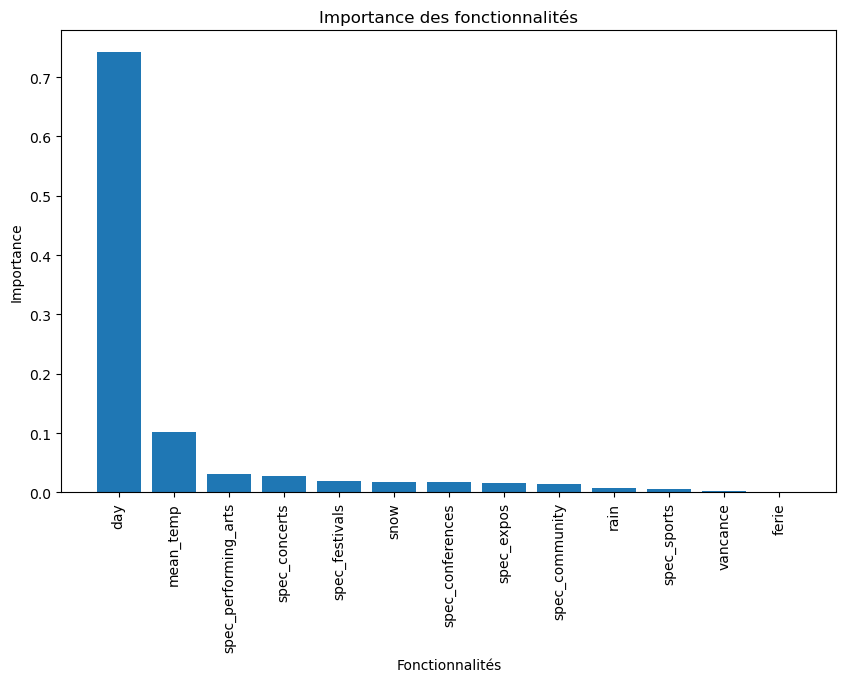

In [5]:
GeneralModel.feature_importance(best_model,X_train)

On peut voir que la feature jour est la plus importante dans notre modèle. Cela s'explique par le fait que les ventes sont très dépendantes du jour de la semaine. Ensuite les features de la météo sont aussi importantes dans notre modèle. Cela s'explique par le fait que les ventes sont très dépendantes de la météo. Cependant, la feature de l'attendance est relativement inutile. On pourrait croire que les ventes sont très dépendantes de l'attendance des évenements autours de la cage aux sports. On décide de garder cette feature  pour le moment car elle pourrait être utile pour prédire les ventes de la cage aux sports lors d'évenements spéciaux avec plus de données%.

### Comparaison avec les prévisions de planifico 

On compare les prévisions de notre modèle avec les prévisions de planifico sur deux types d'erreur:

* Mean Squared Error (MSE) : Le MSE est une mesure de la moyenne des carrés des différences entre les valeurs prédites et les valeurs réelles. Il calcule la moyenne des écarts quadratiques et pénalise davantage les écarts importants entre les valeurs. Le MSE est utile lorsque les erreurs de prédiction plus importantes doivent être plus fortement pénalisées. Une valeur de MSE plus petite indique une meilleure performance du modèle.

* Mean Absolute Error (MAE) : Le MAE est une mesure de la moyenne des valeurs absolues des différences entre les valeurs prédites et les valeurs réelles. Il calcule la moyenne des écarts absolus et ne pénalise pas autant les erreurs importantes. Le MAE est utile lorsque les erreurs de prédiction doivent être considérées de manière égale, quelle que soit leur magnitude. Une valeur de MAE plus petite indique une meilleure performance du modèle.

Notre prevision --> MSE : 3468.016849965432, MAE : 2921.350461425781
Prévision cage --> MSE : 4194.392137211303, MAE : 3096.20875
Notre modèle est meilleur que la prévision de cage


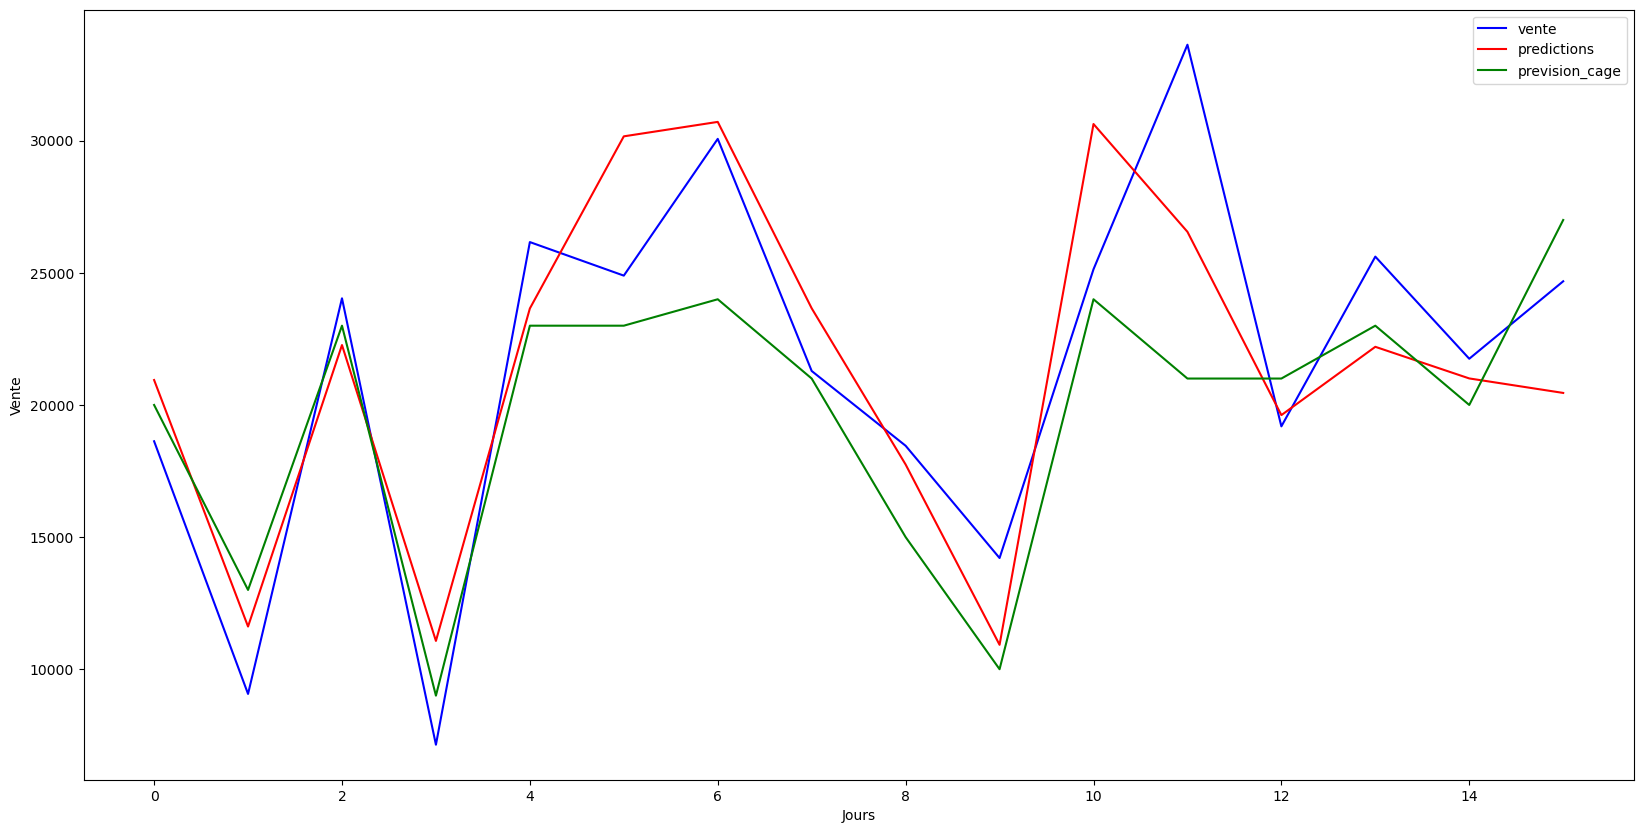

In [6]:
erreur_model,erreur_cage = GeneralModel.compare2planifico(best_model,X_test,y_test,prevision_cage,plot = True)

On peut voir que notre modèle est plus performant que les prévisions de planifico par rapoort au MES ce qui montre que notre présente moins d'erreur importante que les prévisions de planifico. De meme, notre modèle est legerement plus performant que les prévisions de planifico par rapport au MAE ce qui montre que notre modèle présente un peu moins d'erreur en moyenne que les prévisions de planifico. CE faible écart s'explique nottament par le manque de données. En effet, notre modèle est entrainé sur 90 jours de données alors que les prévisions de planifico sont entrainées sur plusieurs années de données. On peut donc s'attendre à ce que notre modèle soit encore mieux performant que les prévisions de planifico.

## Modèle RNN

On utilise un modèle RNN pour prédire les ventes de la cage aux sports. On utilise une cross validation (Random search) pour trouver les meilleurs hyper-paramètres du modèle. On utilise ensuite ces hyper-paramètres pour entrainer notre modèle sur les données d'entrainement. On affiche ensuite les résultats de notre modèle sur les données de test.

### Hyper-paramètres


In [7]:
# Initialisation des hyperparamètres
input_sequence_length = 24
output_sequence_length = 1
hidden_size = 64
num_layers = 2
output_size = 1
batch_size = 64
epochs = 100
learning_rate = 0.001

# Entraînement du modèle
model = modele_rnn.train(X_train, X_test, y_train, y_test, input_sequence_length, output_sequence_length, hidden_size, num_layers, output_size, batch_size, epochs, learning_rate, plot=True)

# Prédictions
predictions = modele_rnn.predict(model, X_test, input_sequence_length, output_sequence_length, plot=True)

# Erreur
erreur_model,erreur_cage = GeneralModel.compare2planifico(predictions,X_test,y_test,prevision_cage,plot = True)

RuntimeError: expected scalar type Double but found Float

### A faire

* Completer le RNN et test
* Tester l'impacte des attendance séparé 
* Demander l'accées à plus de données
